## Data Analytics Questions

You were given a 'practice_dataset.csv' dataset, that contains data about average salary of some school graduates.
Please read in this file here, and explore it.

In [1]:
# load all libs for project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import requests
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz

plt.style.use('dark_background') # make plots stylish
new_colors = ['#ffa726', '#e57373', '#81c784', '#64b5f6', '#ba68c8'] # new colors

c:\Users\Nik\.conda\envs\da_practicum_env\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Data preparation

In [2]:
# load files
try:
    data = pd.read_csv('C:/Users/Nik/Desktop/Tashkent_real_estate_test/practice_dataset.csv')  
    
except:
    print("Could not load data from file 'practice_dataset.csv'")

try:
    school_type = pd.read_json('C:/Users/Nik/Desktop/Tashkent_real_estate_test/school_type.json')
    
except:
    print("Could not load data from file 'school_type.json'")

In [3]:
data.head()

,School Name,School Type,Starting Median Salary,Mid-Career Median Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary
0,Massachusetts Institute of Technology (MIT),1,"$72,200.00","$126,000.00","$76,800.00","$99,200.00","$168,000.00","$220,000.00"
1,California Institute of Technology (CIT),1,"$75,500.00","$123,000.00",NaN,"$104,000.00","$161,000.00",NaN
2,Harvey Mudd College,1,"$71,800.00","$122,000.00",NaN,"$96,000.00","$180,000.00",NaN
3,"Polytechnic University of New York, Brooklyn",1,"$62,400.00","$114,000.00","$66,800.00","$94,300.00","$143,000.00","$190,000.00"
4,Cooper Union,1,"$62,200.00","$114,000.00",NaN,"$80,200.00","$142,000.00",NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   School Name                        269 non-null    object
 1   School Type                        269 non-null    int64 
 2   Starting Median Salary             269 non-null    object
 3   Mid-Career Median Salary           269 non-null    object
 4   Mid-Career 10th Percentile Salary  231 non-null    object
 5   Mid-Career 25th Percentile Salary  269 non-null    object
 6   Mid-Career 75th Percentile Salary  269 non-null    object
 7   Mid-Career 90th Percentile Salary  231 non-null    object
dtypes: int64(1), object(7)
memory usage: 16.9+ KB


In [5]:
data.duplicated().sum() # явных дубликатов не обнаружено

0

In [6]:
data['School Name'].nunique() # количество уникальных школ на 20 меньше количества строчек в дф

249

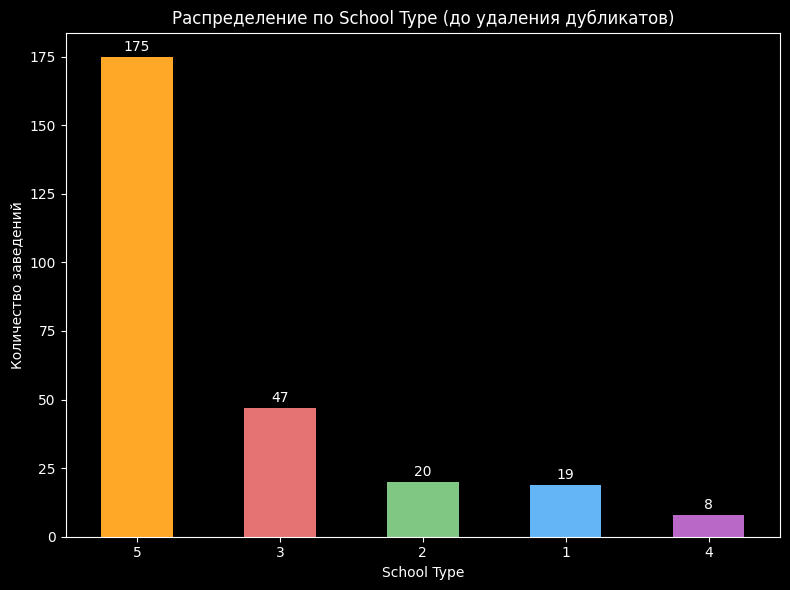

In [7]:
value_counts = data['School Type'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 6))  
ax = value_counts.plot(kind='bar', rot=0, color=new_colors)

# Добавление подписей к столбцам
for i, v in enumerate(value_counts):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize='medium')

plt.title('Распределение по School Type (до удаления дубликатов)')
plt.xlabel('School Type')
plt.ylabel('Количество заведений')
plt.tight_layout()
plt.show()

In [8]:
# найдем дубликаты по столбцу 'School Name'
duplicates = data[data.duplicated(subset=['School Name'], keep=False)]
duplicates['School Type'].value_counts()

2    20
5    19
3     1
Name: School Type, dtype: int64

Среди дубликатов находятся все строки с типом школы 2, чтобы сохранить этот тип в общем датасете принято решение удалить строки с повторяющимися названиями школ и типом = 5. Датасет сократился на ~7,5%

In [9]:
# условие для удаления строк с дубликатами названий школы и типом школы не равным 2
condition = (data.duplicated(subset=['School Name'], keep=False)) & (data['School Type'] == 5)

# удаляем строки по условию
data = data[~condition]

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 268
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   School Name                        250 non-null    object
 1   School Type                        250 non-null    int64 
 2   Starting Median Salary             250 non-null    object
 3   Mid-Career Median Salary           250 non-null    object
 4   Mid-Career 10th Percentile Salary  212 non-null    object
 5   Mid-Career 25th Percentile Salary  250 non-null    object
 6   Mid-Career 75th Percentile Salary  250 non-null    object
 7   Mid-Career 90th Percentile Salary  212 non-null    object
dtypes: int64(1), object(7)
memory usage: 17.6+ KB


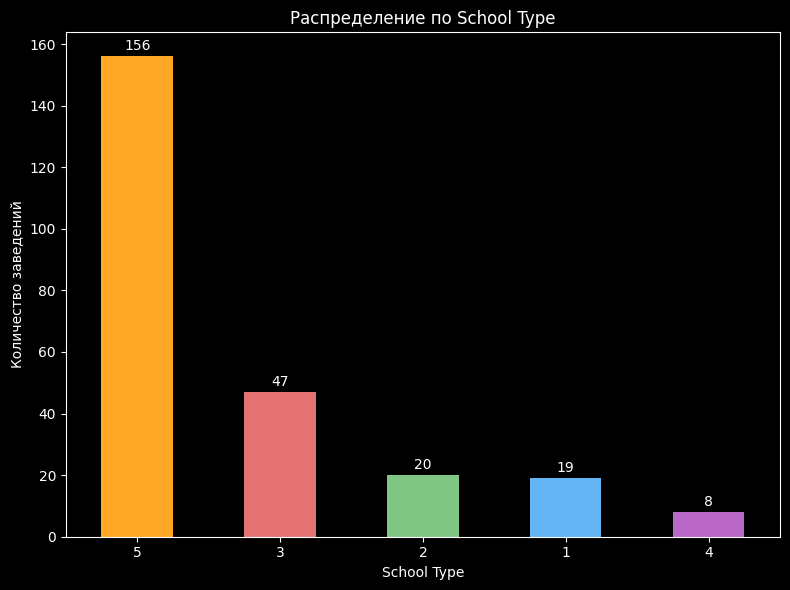

In [11]:
value_counts = data['School Type'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 6))  
ax = value_counts.plot(kind='bar', rot=0, color=new_colors)

# Добавление подписей к столбцам
for i, v in enumerate(value_counts):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize='medium')

plt.title('Распределение по School Type')
plt.xlabel('School Type')
plt.ylabel('Количество заведений')
plt.tight_layout()
plt.show()

In [12]:
# нам пригодится функция для преобразования строки в формат float
def salary_str_to_float(salary_str):
    if pd.isna(salary_str):
        return np.nan
    return float(salary_str.replace('$', '').replace(',', ''))

# и обратная функция
def float_to_salary_str(salary_float):
    if pd.isna(salary_float):
        return np.nan
    return f"${salary_float:,.2f}"

In [13]:
# преобразуем колонки с зарплатами в формат float
data['Mid-Career Median Salary'] = data['Mid-Career Median Salary'].apply(salary_str_to_float)
data['Mid-Career 25th Percentile Salary'] = data['Mid-Career 25th Percentile Salary'].apply(salary_str_to_float)
data['Mid-Career 75th Percentile Salary'] = data['Mid-Career 75th Percentile Salary'].apply(salary_str_to_float)
data['Mid-Career 10th Percentile Salary'] = data['Mid-Career 10th Percentile Salary'].apply(salary_str_to_float)
data['Mid-Career 90th Percentile Salary'] = data['Mid-Career 90th Percentile Salary'].apply(salary_str_to_float)

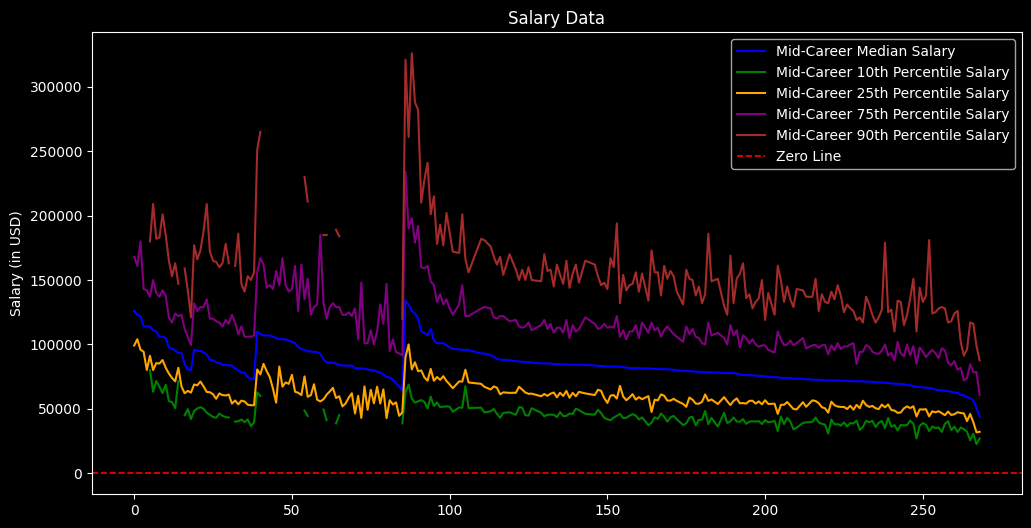

In [14]:
plt.figure(figsize=(12, 6))

colors = ['blue', 'green', 'orange', 'purple', 'brown']

data['Mid-Career Median Salary'].plot(label='Mid-Career Median Salary', color=colors[0])
data['Mid-Career 10th Percentile Salary'].plot(label='Mid-Career 10th Percentile Salary', color=colors[1])
data['Mid-Career 25th Percentile Salary'].plot(label='Mid-Career 25th Percentile Salary', color=colors[2])
data['Mid-Career 75th Percentile Salary'].plot(label='Mid-Career 75th Percentile Salary', color=colors[3])
data['Mid-Career 90th Percentile Salary'].plot(label='Mid-Career 90th Percentile Salary', color=colors[4])

plt.axhline(0, color='red', linestyle='--', linewidth=1.2, label='Zero Line')
plt.ylabel('Salary (in USD)')
plt.title('Salary Data')
plt.legend()

plt.show()

Среди значений зарплат отсутсвуют отрицательные значения, но есть пропуски

In [15]:
# преобразуем колонки с зарплатами обратно во строки
data['Mid-Career Median Salary'] = data['Mid-Career Median Salary'].apply(float_to_salary_str)
data['Mid-Career 25th Percentile Salary'] = data['Mid-Career 25th Percentile Salary'].apply(float_to_salary_str)
data['Mid-Career 75th Percentile Salary'] = data['Mid-Career 75th Percentile Salary'].apply(float_to_salary_str)
data['Mid-Career 10th Percentile Salary'] = data['Mid-Career 10th Percentile Salary'].apply(float_to_salary_str)
data['Mid-Career 90th Percentile Salary'] = data['Mid-Career 90th Percentile Salary'].apply(float_to_salary_str)

In [16]:
data.head()

,School Name,School Type,Starting Median Salary,Mid-Career Median Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary
0,Massachusetts Institute of Technology (MIT),1,"$72,200.00","$126,000.00","$76,800.00","$99,200.00","$168,000.00","$220,000.00"
1,California Institute of Technology (CIT),1,"$75,500.00","$123,000.00",NaN,"$104,000.00","$161,000.00",NaN
2,Harvey Mudd College,1,"$71,800.00","$122,000.00",NaN,"$96,000.00","$180,000.00",NaN
3,"Polytechnic University of New York, Brooklyn",1,"$62,400.00","$114,000.00","$66,800.00","$94,300.00","$143,000.00","$190,000.00"
4,Cooper Union,1,"$62,200.00","$114,000.00",NaN,"$80,200.00","$142,000.00",NaN


## Task 1. 
In the dataset there is a 'School Type' column that has numircal values: they are IDs for keys that are given in 'school_type.json' file. Please, map over these IDs to replace them with their keys. Here is an expected outcome:

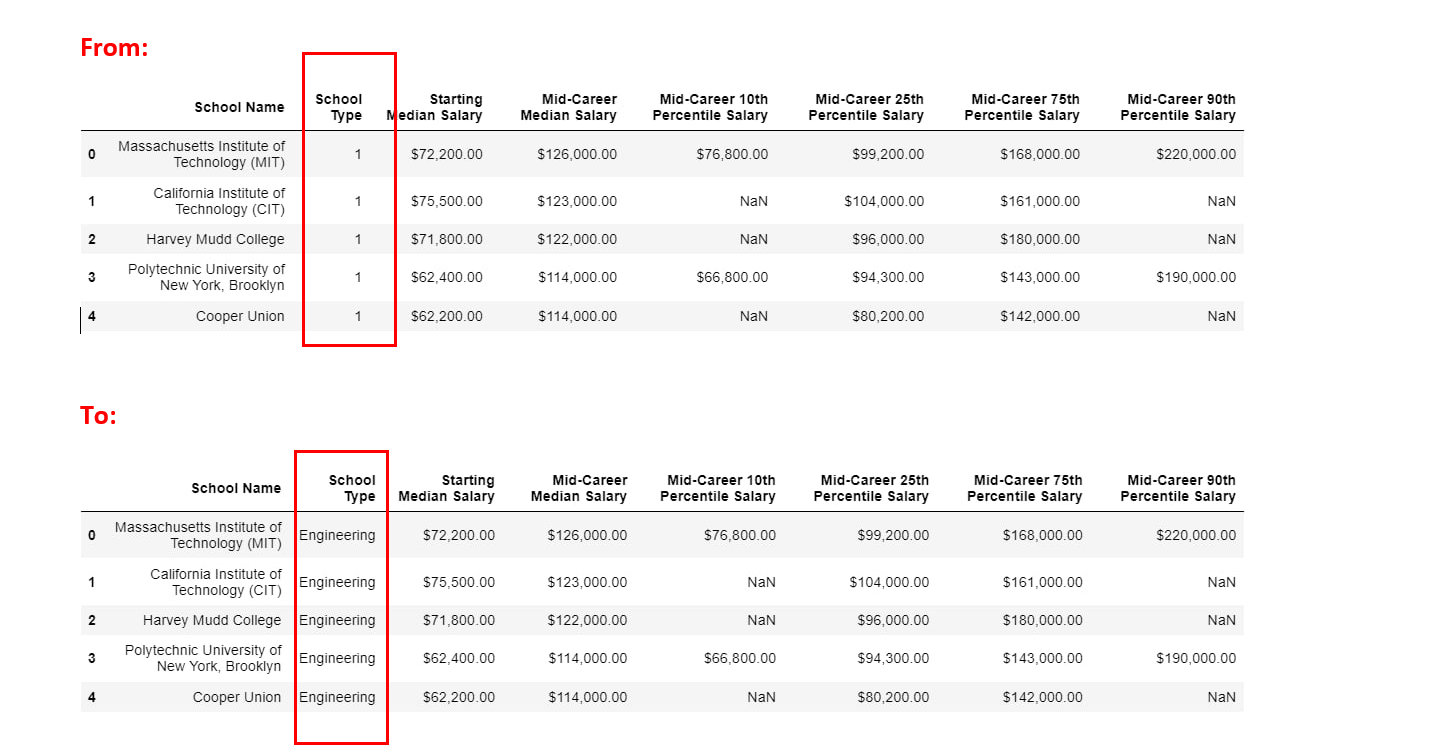

In [17]:
school_type

,ID,VALUE
0,1,Engineering
1,2,Party
2,3,Liberal Arts
3,4,Ivy League
4,5,State


In [18]:
#please code here
data['School Type'] = data['School Type'].map(school_type.set_index('ID')['VALUE'])
data.head()

,School Name,School Type,Starting Median Salary,Mid-Career Median Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary
0,Massachusetts Institute of Technology (MIT),Engineering,"$72,200.00","$126,000.00","$76,800.00","$99,200.00","$168,000.00","$220,000.00"
1,California Institute of Technology (CIT),Engineering,"$75,500.00","$123,000.00",NaN,"$104,000.00","$161,000.00",NaN
2,Harvey Mudd College,Engineering,"$71,800.00","$122,000.00",NaN,"$96,000.00","$180,000.00",NaN
3,"Polytechnic University of New York, Brooklyn",Engineering,"$62,400.00","$114,000.00","$66,800.00","$94,300.00","$143,000.00","$190,000.00"
4,Cooper Union,Engineering,"$62,200.00","$114,000.00",NaN,"$80,200.00","$142,000.00",NaN


## Task 2
We defined a function that takes any 'School Type' value, and estimates rounded average 'Mid-Career Median Salary'for it. However, our funciton is not working. Please find an error and try to fix it.

In [19]:
def function_1(school_type):
    # создадим копию датасета
    data_copy = data.copy()
    
    # переведем во флоут
    data_copy['Mid-Career Median Salary'] = data_copy['Mid-Career Median Salary'].apply(salary_str_to_float)
    
    # вычислим округленное среднее занчение медианной зарплаты
    result = round(data_copy[data_copy['School Type'] == school_type]['Mid-Career Median Salary'].mean(), 2)
    
    return result


If you fix an error, apply this function to values 'Engineering', 'Party', 'Liberal Arts' and print output of the function, the end result must looks like this:

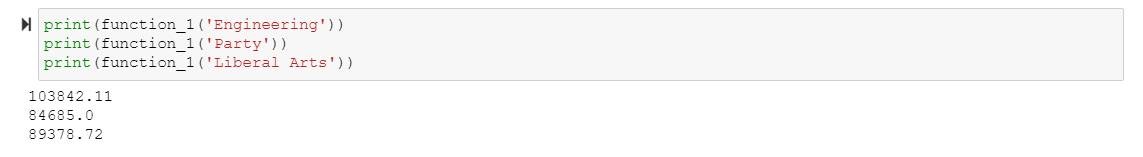

In [20]:
#please code here
display(function_1('Engineering')) 
display(function_1('Party'))
display(function_1('Liberal Arts'))

103842.11

84685.0

89378.72

## Task 3
According to the National Occupational Employment and Wages Estimates, the average salary in the United States is 56,310 USD annaully. Iterate over 'Starting Median Salary' column and assign value 'more than national average' if it is more than 56,310 USD, else 'less than national average'. The result is supposed to be as such:

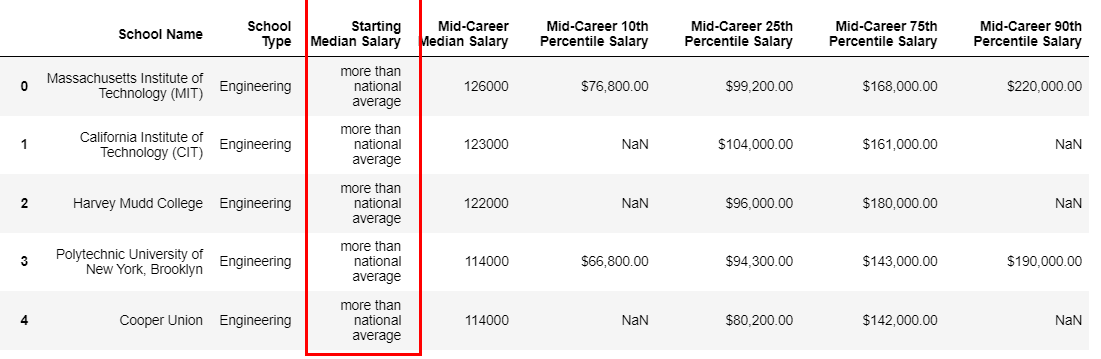

In [21]:
def salary_category(salary):
    if salary > 56310:
        return 'more than national average'
    else:
        return 'less than national average'

data['Starting Median Salary'] = data['Starting Median Salary'].apply(salary_str_to_float).apply(salary_category)

Now, display all state schools that have less than national average salary.

In [22]:
#please code here
t = data.query('(`School Type` == "State") & `Starting Median Salary` == "less than national average"')
t

,School Name,School Type,Starting Median Salary,Mid-Career Median Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary
95,University of Virginia (UVA),State,less than national average,"$103,000.00","$52,200.00","$71,800.00","$146,000.00","$215,000.00"
97,University of California at Los Angeles (UCLA),State,less than national average,"$101,000.00","$51,300.00","$72,500.00","$139,000.00","$193,000.00"
98,"University of California, San Diego (UCSD)",State,less than national average,"$101,000.00","$51,700.00","$75,400.00","$131,000.00","$177,000.00"
99,"University of California, Davis",State,less than national average,"$99,600.00","$52,000.00","$71,600.00","$135,000.00","$202,000.00"
100,University of Colorado - Boulder (UCB),State,less than national average,"$97,600.00","$51,600.00","$69,000.00","$128,000.00","$187,000.00"
...,...,...,...,...,...,...,...,...
264,Austin Peay State University,State,less than national average,"$59,200.00","$32,200.00","$40,500.00","$73,900.00","$96,200.00"
265,Pittsburg State University,State,less than national average,"$58,200.00","$25,600.00","$46,000.00","$84,600.00","$117,000.00"
266,Southern Utah University,State,less than national average,"$56,500.00","$30,700.00","$39,700.00","$78,400.00","$116,000.00"
267,Montana State University - Billings,State,less than national average,"$50,600.00","$22,600.00","$31,800.00","$78,500.00","$98,900.00"


## Task4
You might have realised that some columns have missing values. Display all rows that has at least one missing value in any column. Then, consider how would you handle these missing values? Please, describe below your thoughts

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 268
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   School Name                        250 non-null    object
 1   School Type                        250 non-null    object
 2   Starting Median Salary             250 non-null    object
 3   Mid-Career Median Salary           250 non-null    object
 4   Mid-Career 10th Percentile Salary  212 non-null    object
 5   Mid-Career 25th Percentile Salary  250 non-null    object
 6   Mid-Career 75th Percentile Salary  250 non-null    object
 7   Mid-Career 90th Percentile Salary  212 non-null    object
dtypes: object(8)
memory usage: 17.6+ KB


In [24]:
t = data[data.isnull().any(axis=1)]
t

,School Name,School Type,Starting Median Salary,Mid-Career Median Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary
1,California Institute of Technology (CIT),Engineering,more than national average,"$123,000.00",NaN,"$104,000.00","$161,000.00",NaN
2,Harvey Mudd College,Engineering,more than national average,"$122,000.00",NaN,"$96,000.00","$180,000.00",NaN
4,Cooper Union,Engineering,more than national average,"$114,000.00",NaN,"$80,200.00","$142,000.00",NaN
15,New Mexico Institute of Mining and Technology ...,Engineering,less than national average,"$93,400.00",NaN,"$67,400.00","$123,000.00",NaN
31,Randolph-Macon College,Party,less than national average,"$83,600.00",NaN,"$54,100.00","$123,000.00",NaN
41,Amherst College,Liberal Arts,less than national average,"$107,000.00",NaN,"$84,900.00","$162,000.00",NaN
43,Bowdoin College,Liberal Arts,less than national average,"$107,000.00",NaN,"$74,600.00","$146,000.00",NaN
44,College of the Holy Cross,Liberal Arts,less than national average,"$106,000.00",NaN,"$65,600.00","$143,000.00",NaN
45,Occidental College,Liberal Arts,less than national average,"$105,000.00",NaN,"$54,800.00","$157,000.00",NaN
46,Washington and Lee University,Liberal Arts,less than national average,"$104,000.00",NaN,"$82,800.00","$146,000.00",NaN


#please opine here  
Всего в датасете было пропущено 38 строчек. Все пропуски приходятся на столбцы со значениями зарплаты в 10 и 90 процентилях. Такие пропуски скорее всего могли бы быть вызваны техническим сбоем при подготовке данных к выгрузе. 
Можно попробовать поисследовать распределение зарплат, предсказать с использованием интерполяции значения зарплат в 10 и 90 процентилях.

In [25]:
data_full = data.dropna().copy() # рассмотрим все полные данные

In [26]:
# преобразуем колонки с зарплатами в формат float
data_full['Mid-Career Median Salary'] = data_full['Mid-Career Median Salary'].apply(salary_str_to_float)
data_full['Mid-Career 25th Percentile Salary'] = data_full['Mid-Career 25th Percentile Salary'].apply(salary_str_to_float)
data_full['Mid-Career 75th Percentile Salary'] = data_full['Mid-Career 75th Percentile Salary'].apply(salary_str_to_float)
data_full['Mid-Career 10th Percentile Salary'] = data_full['Mid-Career 10th Percentile Salary'].apply(salary_str_to_float)
data_full['Mid-Career 90th Percentile Salary'] = data_full['Mid-Career 90th Percentile Salary'].apply(salary_str_to_float)


Рассмотрим полные данные на предмет нормальности распределения зарплат и поищем способ заполнить пропуски.

In [27]:
data_full.head()

,School Name,School Type,Starting Median Salary,Mid-Career Median Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary
0,Massachusetts Institute of Technology (MIT),Engineering,more than national average,126000.0,76800.0,99200.0,168000.0,220000.0
3,"Polytechnic University of New York, Brooklyn",Engineering,more than national average,114000.0,66800.0,94300.0,143000.0,190000.0
5,Worcester Polytechnic Institute (WPI),Engineering,more than national average,114000.0,80000.0,91200.0,137000.0,180000.0
6,Carnegie Mellon University (CMU),Engineering,more than national average,111000.0,63300.0,80100.0,150000.0,209000.0
7,Rensselaer Polytechnic Institute (RPI),Engineering,more than national average,110000.0,71600.0,85500.0,140000.0,182000.0


In [28]:
# вычислим отклонения от медианы 25-го и 75-го перцентилей
dev = data_full[['Mid-Career Median Salary', 'Mid-Career 25th Percentile Salary', 'Mid-Career 75th Percentile Salary']].copy()

dev['25th Deviation'] = dev['Mid-Career Median Salary'] - dev['Mid-Career 25th Percentile Salary']
dev['75th Deviation'] = dev['Mid-Career 75th Percentile Salary'] - dev['Mid-Career Median Salary']
dev['dev'] = dev['75th Deviation'] - dev['25th Deviation']

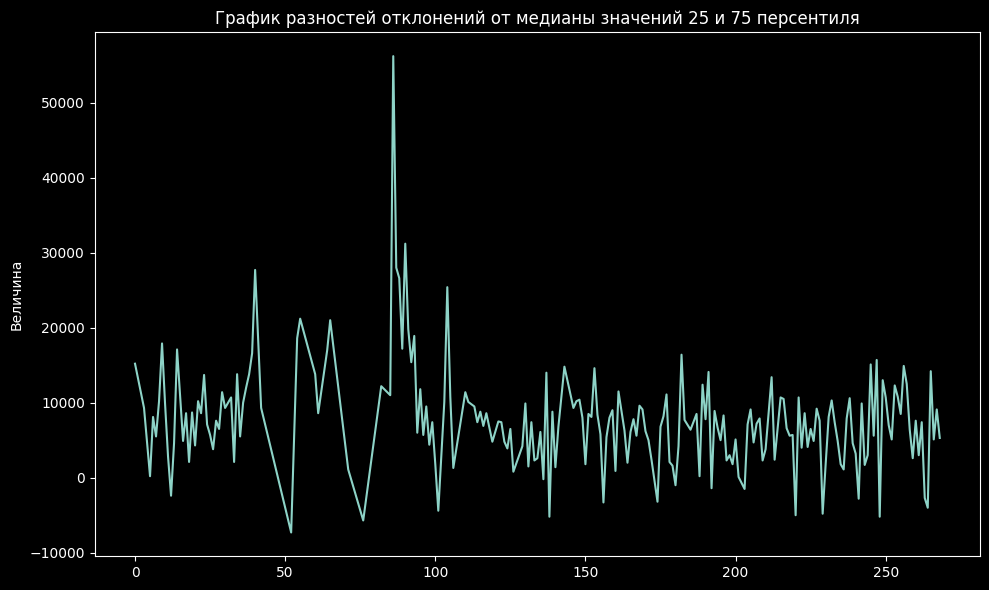

In [29]:
dev['dev'].plot(kind='line', figsize=(10, 6))
plt.ylabel('Величина')
plt.title('График разностей отклонений от медианы значений 25 и 75 персентиля')
plt.tight_layout()
plt.show()

Есть основания предполагать, что зарплаты распределены не нормально, а как-то иначе, поскольку отклонения от медианы 25 и 75 персентиля не равны, то есть сами значения не равноудалены от медианы.  Попробуем нормализовать зарплаты по 90 персентилю и визуализировать распределение чтобы подобрать апроксимирующую функцию для вычисления пропусков в дс.

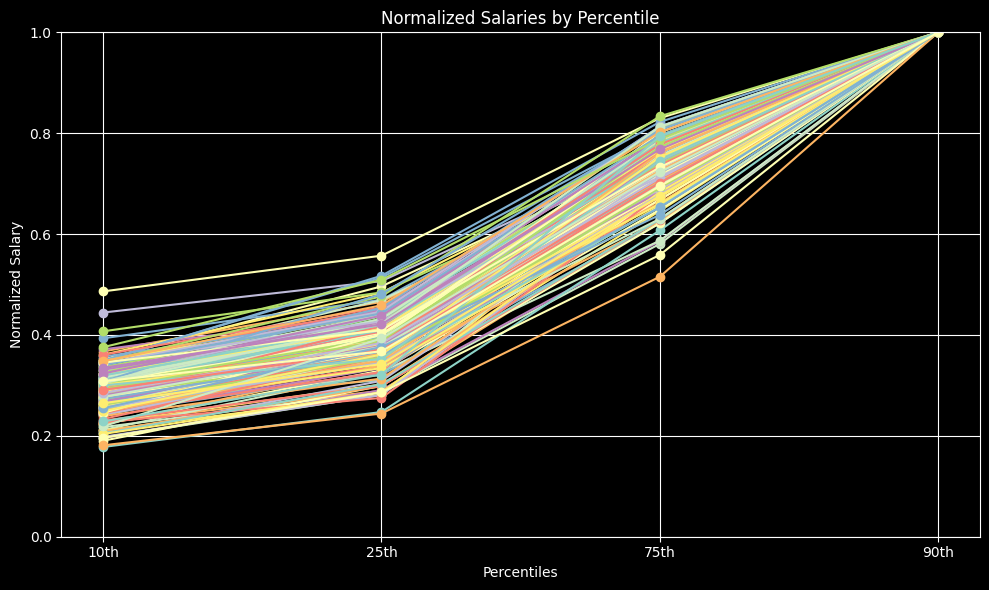

In [30]:
# нормализуем данные по 90 перцентилю чтобы посмотреть на вид распределения зарплат 
data_full_n = data_full.copy()  # Создаем копию исходного датасета
data_full_n['Mid-Career 10th Percentile Salary'] = (data_full['Mid-Career 10th Percentile Salary'] / data_full['Mid-Career 90th Percentile Salary']).copy()
data_full_n['Mid-Career 25th Percentile Salary'] = (data_full['Mid-Career 25th Percentile Salary'] / data_full['Mid-Career 90th Percentile Salary']).copy()
data_full_n['Mid-Career 75th Percentile Salary'] = (data_full['Mid-Career 75th Percentile Salary'] / data_full['Mid-Career 90th Percentile Salary']).copy()
data_full_n['Mid-Career 90th Percentile Salary'] = (data_full['Mid-Career 90th Percentile Salary'] / data_full['Mid-Career 90th Percentile Salary']).copy()

percentiles = ['10th', '25th', '75th', '90th']
normalized_data = [data_full_n[f'Mid-Career {p} Percentile Salary'] for p in percentiles]

plt.figure(figsize=(10, 6))
plt.plot(percentiles, normalized_data, marker='o')
plt.xlabel('Percentiles')
plt.ylabel('Normalized Salary')
plt.title('Normalized Salaries by Percentile')
plt.grid(True)
plt.ylim(0, 1)  # Устанавливаем пределы для оси Y от 0 до 1
plt.tight_layout()


plt.show()

Можно предположить, что распределение значений зарплат поддается аппроксимации линейной функции вида y=kx+b

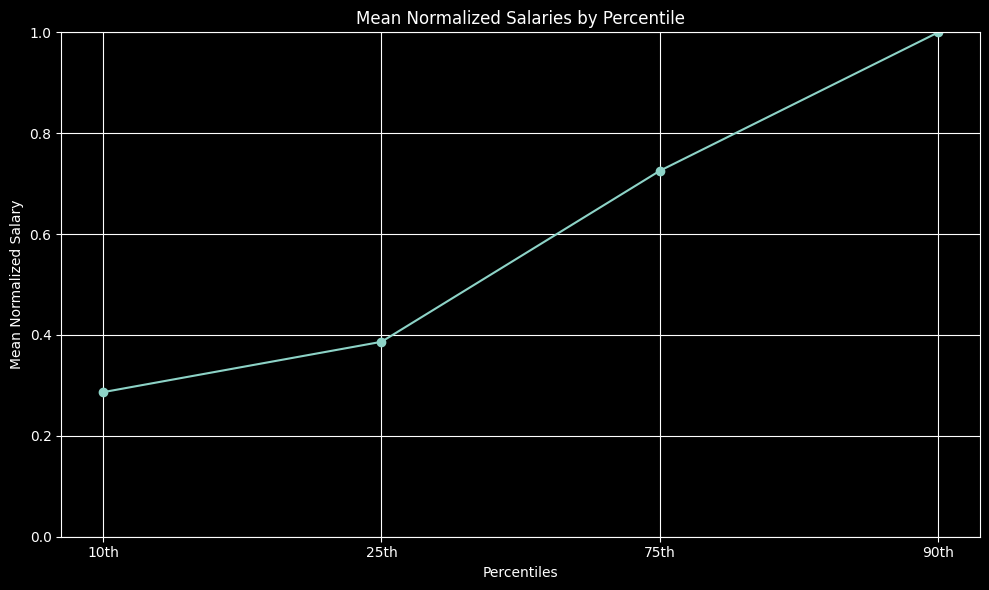

In [31]:
percentiles = ['10th', '25th', '75th', '90th']

# Нормализуем данные по 90 перцентилю
data_full_n = data_full.copy()  # Создаем копию исходного датасета
for p in percentiles:
    data_full_n[f'Mid-Career {p} Percentile Salary'] = data_full_n[f'Mid-Career {p} Percentile Salary'] / data_full_n['Mid-Career 90th Percentile Salary']

# Усредняем значения по каждому перцентилю
mean_values = [data_full_n[f'Mid-Career {p} Percentile Salary'].mean() for p in percentiles]

plt.figure(figsize=(10, 6))
plt.plot(percentiles, mean_values, marker='o')
plt.xlabel('Percentiles')
plt.ylabel('Mean Normalized Salary')
plt.title('Mean Normalized Salaries by Percentile')
plt.grid(True)
plt.ylim(0, 1)  # Устанавливаем пределы для оси Y от 0 до 1
plt.tight_layout()

plt.show()

По нашим грубым прикидкам получается, что распределение зарплат имеет скорее линейную природу нежели какую-то иную. Также можно дополнительно проверить выборку на принадлежность к нормально распределенной ГС выполнив тест Шапиро-Уилка.   
Попробуем линейно интерполивать имеющиеся значения для рассчета пропущенных значений 10 и 90 персентилей в датасете. Коэффициенты интерполяции подберем вручную.

In [32]:
# Функция для интерполяции пропущенных значений в 10-м и 90-м перцентилях
def interpolate_percentiles(row):
    if pd.notnull(row['Mid-Career 10th Percentile Salary']):
        return row['Mid-Career 10th Percentile Salary']
    else:
        # Интерполируем пропущенное значение
        Q1 = float(row['Mid-Career 25th Percentile Salary'].replace('$', '').replace(',', ''))
        Q3 = float(row['Mid-Career 75th Percentile Salary'].replace('$', '').replace(',', ''))
        interpolated_value = Q1 - 0.4 * (Q3 - Q1) # берем 40% от интерквартильного размаха и вычитаем из 25 персентиля чтобы опуститься до 10 персентиля, так как данные немного скошены вправо 
        return f"${interpolated_value:,.2f}"

def interpolate_percentiles_90(row):
    if pd.notnull(row['Mid-Career 90th Percentile Salary']):
        return row['Mid-Career 90th Percentile Salary']
    else:
        # Интерполируем пропущенное значение
        Q1 = float(row['Mid-Career 25th Percentile Salary'].replace('$', '').replace(',', ''))
        Q3 = float(row['Mid-Career 75th Percentile Salary'].replace('$', '').replace(',', ''))
        interpolated_value = Q3 + 0.6 * (Q3 - Q1) # берем 60% от интерквартильного размаха и прибавляем к 75 персентилю чтобы подняться до 90 персентиля
        return f"${interpolated_value:,.2f}"

# Применяем функции интерполяции к каждой строке
data['Mid-Career 10th Percentile Salary'] = data.apply(interpolate_percentiles, axis=1)
data['Mid-Career 90th Percentile Salary'] = data.apply(interpolate_percentiles_90, axis=1)


In [33]:
data.head()

,School Name,School Type,Starting Median Salary,Mid-Career Median Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary
0,Massachusetts Institute of Technology (MIT),Engineering,more than national average,"$126,000.00","$76,800.00","$99,200.00","$168,000.00","$220,000.00"
1,California Institute of Technology (CIT),Engineering,more than national average,"$123,000.00","$81,200.00","$104,000.00","$161,000.00","$195,200.00"
2,Harvey Mudd College,Engineering,more than national average,"$122,000.00","$62,400.00","$96,000.00","$180,000.00","$230,400.00"
3,"Polytechnic University of New York, Brooklyn",Engineering,more than national average,"$114,000.00","$66,800.00","$94,300.00","$143,000.00","$190,000.00"
4,Cooper Union,Engineering,more than national average,"$114,000.00","$55,480.00","$80,200.00","$142,000.00","$179,080.00"


In [34]:
# преобразуем колонки с зарплатами в формат float
data['Mid-Career Median Salary'] = data['Mid-Career Median Salary'].apply(salary_str_to_float)
data['Mid-Career 25th Percentile Salary'] = data['Mid-Career 25th Percentile Salary'].apply(salary_str_to_float)
data['Mid-Career 75th Percentile Salary'] = data['Mid-Career 75th Percentile Salary'].apply(salary_str_to_float)
data['Mid-Career 10th Percentile Salary'] = data['Mid-Career 10th Percentile Salary'].apply(salary_str_to_float)
data['Mid-Career 90th Percentile Salary'] = data['Mid-Career 90th Percentile Salary'].apply(salary_str_to_float)

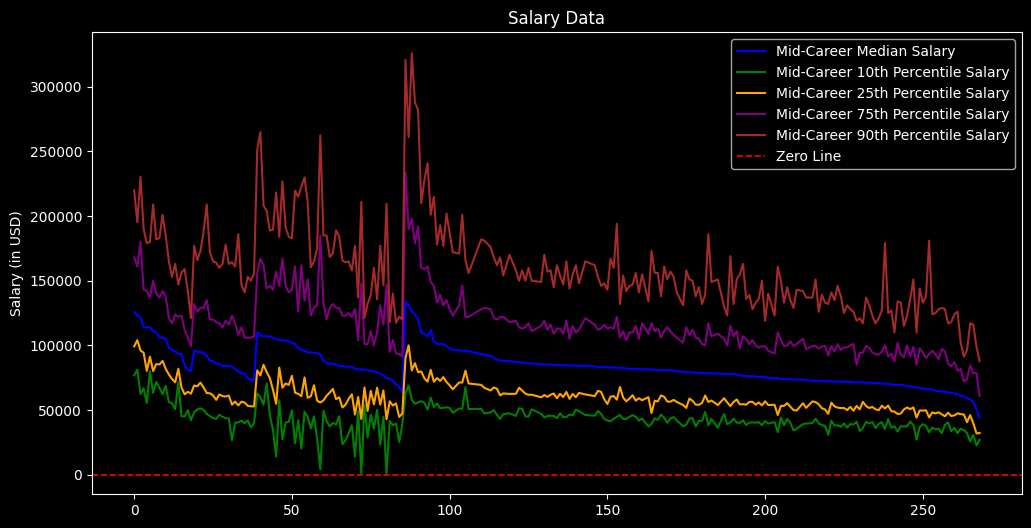

In [35]:
plt.figure(figsize=(12, 6))

colors = ['blue', 'green', 'orange', 'purple', 'brown']

data['Mid-Career Median Salary'].plot(label='Mid-Career Median Salary', color=colors[0])
data['Mid-Career 10th Percentile Salary'].plot(label='Mid-Career 10th Percentile Salary', color=colors[1])
data['Mid-Career 25th Percentile Salary'].plot(label='Mid-Career 25th Percentile Salary', color=colors[2])
data['Mid-Career 75th Percentile Salary'].plot(label='Mid-Career 75th Percentile Salary', color=colors[3])
data['Mid-Career 90th Percentile Salary'].plot(label='Mid-Career 90th Percentile Salary', color=colors[4])

plt.axhline(0, color='red', linestyle='--', linewidth=1.2, label='Zero Line')
plt.ylabel('Salary (in USD)')
plt.title('Salary Data')
plt.legend()

plt.show()

Судя по графику результатом заполнения пропусков стала правдоподобная картина распределения зарплат в 10 и 90 персентилях. 

In [36]:
# преобразуем колонки с зарплатами обратно во строки
data['Mid-Career Median Salary'] = data['Mid-Career Median Salary'].apply(float_to_salary_str)
data['Mid-Career 25th Percentile Salary'] = data['Mid-Career 25th Percentile Salary'].apply(float_to_salary_str)
data['Mid-Career 75th Percentile Salary'] = data['Mid-Career 75th Percentile Salary'].apply(float_to_salary_str)
data['Mid-Career 10th Percentile Salary'] = data['Mid-Career 10th Percentile Salary'].apply(float_to_salary_str)
data['Mid-Career 90th Percentile Salary'] = data['Mid-Career 90th Percentile Salary'].apply(float_to_salary_str)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 268
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   School Name                        250 non-null    object
 1   School Type                        250 non-null    object
 2   Starting Median Salary             250 non-null    object
 3   Mid-Career Median Salary           250 non-null    object
 4   Mid-Career 10th Percentile Salary  250 non-null    object
 5   Mid-Career 25th Percentile Salary  250 non-null    object
 6   Mid-Career 75th Percentile Salary  250 non-null    object
 7   Mid-Career 90th Percentile Salary  250 non-null    object
dtypes: object(8)
memory usage: 17.6+ KB


## Task 5
Please visit this web page: https://www.upgradabroad.com/articles/forbes-unveils-americas-top-colleges-2022-list-news/
It contains several tables, that show some university rankings. Scroll till you reach "Forbes college rankings" field. First, scrape HTML table from this field and save as forbes_ranking. Then, write a function that creates new column "Ranked on Forbes" in practice_dataset and accepts Boolean values (True or False) based on the fact whether this university in forbes_ranking or not. Final result should look as follows:

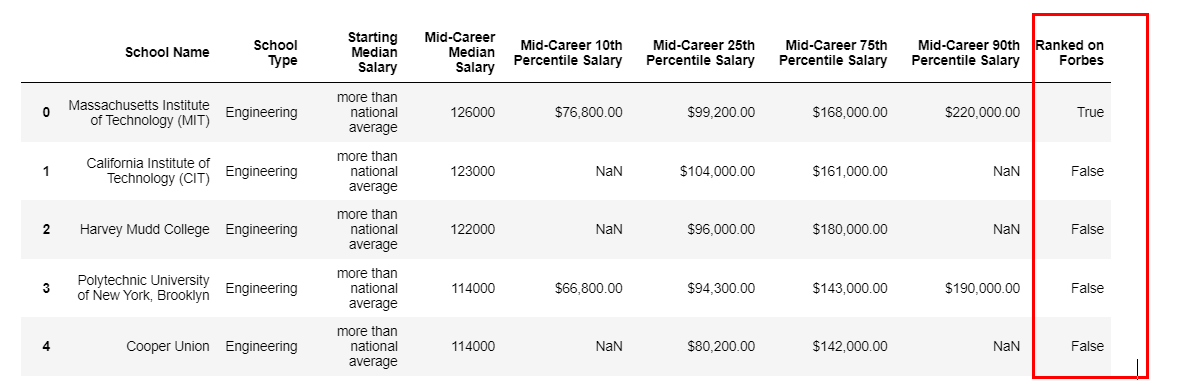

In [38]:
website_url = requests.get('https://www.upgradabroad.com/articles/forbes-unveils-americas-top-colleges-2022-list-news/').text

In [39]:
soup = BeautifulSoup(website_url,'lxml')
print(soup.prettify())

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1.0 user-scalable=no" name="viewport"/>
  <link href="/static/style/bootstrap.min.css" rel="stylesheet" type="text/css"/>
  <link charset="UTF-8" href="/static/style/slick.min.css" rel="stylesheet" type="text/css"/>
  <meta content="6nozxi3l0jsyntr470p6cs7hsu8sfh" name="facebook-domain-verification"/>
  <meta content="en-IN" property="og:locale"/>
  <title>
   Forbes Unveils America's Top Colleges 2022 List
  </title>
  <meta content="index,follow,max-snippet:-1,max-image-preview:large,max-video-preview:-1" name="robots"/>
  <meta content="Forbes has released the 2022 America’s Top Colleges List. Over 450 colleges and universities have been ranked by the media house." name="description"/>
  <meta content="Forbes Unveils America's Top Colleges 2022 List" property="og:title"/>
  <meta content="Forbes has released the 2022 America’s Top Colleges List. Over 450 colleges and

In [40]:
My_table = soup.find('figure',{'class':'table'})
My_table

<figure class="table"><table><tbody><tr><td><strong>Rank</strong></td><td><strong>Colleges</strong></td><td><strong>State</strong></td></tr><tr><td>1</td><td>Massachusetts Institute of Technology</td><td>Massachusetts</td></tr><tr><td>2</td><td><a href="/university/usa/stanford-university-687">Stanford University</a></td><td>California</td></tr><tr><td>2</td><td>University of California, Berkeley</td><td>California</td></tr><tr><td>4</td><td><a href="/university/usa/princeton-university-776">Princeton University</a></td><td>New Jersey</td></tr><tr><td>5</td><td>Columbia University</td><td>New York</td></tr><tr><td>6</td><td>University of California, Los Angeles</td><td>California</td></tr><tr><td>7</td><td>Williams College</td><td>Massachusetts</td></tr><tr><td>8</td><td><a href="/university/usa/yale-university-779">Yale University</a></td><td>Connecticut</td></tr><tr><td>9</td><td><a href="/university/usa/duke-university-729">Duke University</a></td><td>North Carolina</td></tr><tr><td

In [41]:
rows_data = My_table.find_all('td')
rows_data

[<td><strong>Rank</strong></td>,
 <td><strong>Colleges</strong></td>,
 <td><strong>State</strong></td>,
 <td>1</td>,
 <td>Massachusetts Institute of Technology</td>,
 <td>Massachusetts</td>,
 <td>2</td>,
 <td><a href="/university/usa/stanford-university-687">Stanford University</a></td>,
 <td>California</td>,
 <td>2</td>,
 <td>University of California, Berkeley</td>,
 <td>California</td>,
 <td>4</td>,
 <td><a href="/university/usa/princeton-university-776">Princeton University</a></td>,
 <td>New Jersey</td>,
 <td>5</td>,
 <td>Columbia University</td>,
 <td>New York</td>,
 <td>6</td>,
 <td>University of California, Los Angeles</td>,
 <td>California</td>,
 <td>7</td>,
 <td>Williams College</td>,
 <td>Massachusetts</td>,
 <td>8</td>,
 <td><a href="/university/usa/yale-university-779">Yale University</a></td>,
 <td>Connecticut</td>,
 <td>9</td>,
 <td><a href="/university/usa/duke-university-729">Duke University</a></td>,
 <td>North Carolina</td>,
 <td>10</td>,
 <td><a href="/university/usa

In [42]:
rank = []
colleges = []
state = []

for i in range(0, len(rows_data), 3):
    rank.append(rows_data[i].get_text().strip())
    colleges.append(rows_data[i + 1].get_text().strip())
    state.append(rows_data[i + 2].get_text().strip())


forbes_ranking = pd.DataFrame({
    'Rank': rank,
    'Colleges': colleges,
    'State': state
})

In [43]:
forbes_ranking = forbes_ranking.iloc[1:].reset_index(drop=True)

In [44]:
forbes_ranking

,Rank,Colleges,State
0,1,Massachusetts Institute of Technology,Massachusetts
1,2,Stanford University,California
2,2,"University of California, Berkeley",California
3,4,Princeton University,New Jersey
4,5,Columbia University,New York
5,6,"University of California, Los Angeles",California
6,7,Williams College,Massachusetts
7,8,Yale University,Connecticut
8,9,Duke University,North Carolina
9,10,University of Pennsylvania,Pennsylvania


In [45]:
def add_forbes_ranking(data, forbes_ranking_list):
    data['Ranked on Forbes'] = False
    
    for university in forbes_ranking_list['Colleges'].values:
        for school_name in data['School Name'].values:
            similarity = fuzz.ratio(university.lower(), school_name.lower())
            if similarity >= 90:
                data.loc[data['School Name'] == school_name, 'Ranked on Forbes'] = True
    
    return data

data = add_forbes_ranking(data, forbes_ranking)

In [46]:
data.query('`Ranked on Forbes` == True')

,School Name,School Type,Starting Median Salary,Mid-Career Median Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary,Ranked on Forbes
0,Massachusetts Institute of Technology (MIT),Engineering,more than national average,"$126,000.00","$76,800.00","$99,200.00","$168,000.00","$220,000.00",True
41,Amherst College,Liberal Arts,less than national average,"$107,000.00","$54,060.00","$84,900.00","$162,000.00","$208,260.00",True
50,Williams College,Liberal Arts,less than national average,"$102,000.00","$49,760.00","$76,400.00","$143,000.00","$182,960.00",True
86,Dartmouth College,Ivy League,more than national average,"$134,000.00","$63,100.00","$90,200.00","$234,000.00","$321,000.00",True
87,Princeton University,Ivy League,more than national average,"$131,000.00","$68,900.00","$100,000.00","$190,000.00","$261,000.00",True
88,Yale University,Ivy League,more than national average,"$126,000.00","$58,000.00","$80,600.00","$198,000.00","$326,000.00",True
89,Harvard University,Ivy League,more than national average,"$124,000.00","$54,800.00","$86,200.00","$179,000.00","$288,000.00",True
90,University of Pennsylvania,Ivy League,more than national average,"$120,000.00","$55,900.00","$79,200.00","$192,000.00","$282,000.00",True
91,Cornell University,Ivy League,more than national average,"$110,000.00","$56,800.00","$79,800.00","$160,000.00","$210,000.00",True
92,Brown University,Ivy League,less than national average,"$109,000.00","$55,400.00","$74,400.00","$159,000.00","$228,000.00",True


In [47]:
data.head()

,School Name,School Type,Starting Median Salary,Mid-Career Median Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary,Ranked on Forbes
0,Massachusetts Institute of Technology (MIT),Engineering,more than national average,"$126,000.00","$76,800.00","$99,200.00","$168,000.00","$220,000.00",True
1,California Institute of Technology (CIT),Engineering,more than national average,"$123,000.00","$81,200.00","$104,000.00","$161,000.00","$195,200.00",False
2,Harvey Mudd College,Engineering,more than national average,"$122,000.00","$62,400.00","$96,000.00","$180,000.00","$230,400.00",False
3,"Polytechnic University of New York, Brooklyn",Engineering,more than national average,"$114,000.00","$66,800.00","$94,300.00","$143,000.00","$190,000.00",False
4,Cooper Union,Engineering,more than national average,"$114,000.00","$55,480.00","$80,200.00","$142,000.00","$179,080.00",False


## Task 6
If time spent by website visitors on two difernet landing pages could be drawn as below, so that average time spent is the same for both. Based on the graph solely, what do you think what landing page (red or purple) performes better and why?

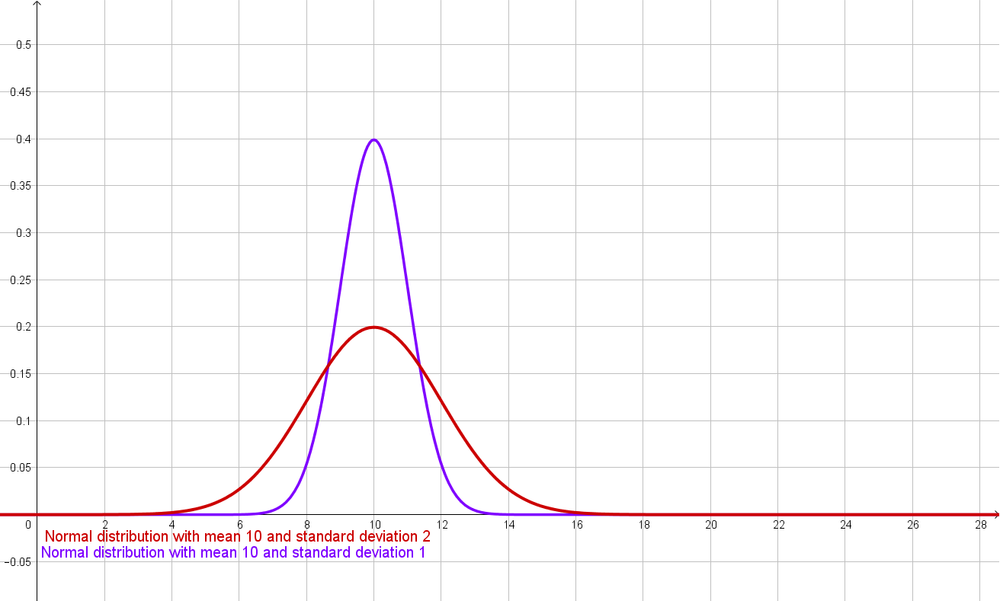

Для ответа на вопрос о том, какой лендинг работает лучше, нам не хватает информации о конкретных целях данного сравнения и метриках его успеха. Нам важно понимать, какие действия пользователей считаются желаемыми на лендинге. Например, если нашей целью является только увеличение среднего времени, проведенного пользователями на лендинге, то фиолетовый лендинг, со стандартным отклонением равным 1, может считаться лучше, так как он обеспечивает более стабильное и предсказуемое время пользователей на сайте.

Однако, если нашей целью является увеличение конверсии или выполнение определенных целевых действий на лендинге, то нам нужно дополнительно анализировать метрики, связанные с этими действиями. Возможно, красный лендинг, несмотря на большее стандартное отклонение (2), более успешно мотивирует пользователей совершать нужные нам действия.

Чтобы квалифицированно ответить на вопрос какой лендинг работает лучше, необходимо прояснить у заказчика этого сравнения какие конкретные цели стоят перед тестом, как именно он оценивает "успех" проекта. Необходимо провести дополнительный анализ данных, связанных с желаемыми действиями пользователей, чтобы принять информированное решение.

To answer the question of which landing page performs better, we lack information about the specific goals of this comparison and the metrics of its success. It is important for us to understand what user actions are considered desirable on the landing page. For example, if our goal is only to increase the average time spent by users on a landing page, then a purple landing page, with a standard deviation of 1, might be considered better since it provides a more stable and predictable user time on the website.

However, if our goal is to increase conversion or performance of certain actions on the landing page, then we need to further analyze the metrics associated with these actions. Perhaps the red landing page, despite its larger standard deviation (2), is more successful in motivating users to take the actions we need.

In order to competently answer the question of which landing page works better, it is necessary to clarify with the customer of this comparison what specific goals the test has, and how exactly he evaluates the “success” of the project. Additional analysis of data related to desired user actions is necessary to make an informed decision.

## Task 7
if a die is thrown 6 times, what is the probability of 3 of the numbers being even numbers?

Чтобы вычислить вероятность выпадения ровно 3 четных чисел при броске шестигранной кости 6 раз, надо использовать формулу биномиальной вероятности.  
В этом случае вероятность успеха, то есть выпадения четного числа, в одном испытании равна 3/6 (поскольку из 6 сторон 3 четных числа),
и вероятность неудачи, то есть выпадение нечетного числа, также равна 3/6.

Формула биномиальной вероятности выглядит следующим образом:

P(X=k)=(nk​)⋅p^k⋅(1−p)^(n−k)

Где:

P(X=k) — вероятность получения ровно k успехов.  
n — общее количество попыток (в данном случае 6 бросков кубика).  
k — желаемое количество успешных результатов (в данном случае 3 четных числа).  
p — вероятность успеха в одном испытании (выпадение четного числа).  
(nk) представляет собой биномиальный коэффициент, который отражает количество способов выбрать k успехов из n испытаний.  

In [48]:
# Number of trials (throws of the die)
n = 6

# Number of successful outcomes (even numbers)
k = 3

# Probability of success on a single trial (rolling an even number)
p = 3/6

# Calculate the binomial coefficient
binomial_coefficient = math.comb(n, k)

# Calculate the probability using the binomial probability formula
probability = binomial_coefficient * (p ** k) * ((1 - p) ** (n - k))

print(f"The probability of getting exactly 3 even numbers in 6 throws of the die is: {probability:.4f}")

The probability of getting exactly 3 even numbers in 6 throws of the die is: 0.3125


## Dashboard




In [49]:
# cохранение DataFrame в CSV-файл
#data.to_csv('test_data.csv', index=False)

dashboard = https://public.tableau.com/views/Test_Tashkent_AxTechnology/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link